In [ ]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import get_typestore, Stores, get_types_from_msg
import pandas as pd

occluded_bag_path = "data/humble_occluded_run"
open_bag_path = "data/humble_open_run"
straight_line_bag_path = "data/humble_straight_line_run"

typestore = get_typestore(Stores.ROS2_HUMBLE)

#register custom message
msg_text = open("gps_driver_msgs/msg/GpsMsg.msg").read()
add_types = get_types_from_msg(msg_text, "gps_driver_msgs/msg/GpsMsg")
typestore.register(add_types)


def bag_to_df(bag_path, typestore):
    rows = []

    with Reader(bag_path) as reader:
        for connection, timestamp, rawdata in reader.messages():

            if connection.topic != "/gps":
                continue

            msg = typestore.deserialize_cdr(rawdata, connection.msgtype)

            rows.append({
                "bag_time_ns": int(timestamp),
                "stamp_sec": int(msg.header.stamp.sec),
                "stamp_nanosec": int(msg.header.stamp.nanosec),
                "frame_id": msg.header.frame_id,

                "latitude": float(msg.latitude),
                "longitude": float(msg.longitude),
                "altitude": float(msg.altitude),
                "hdop": float(msg.hdop),

                "utm_easting": float(msg.utm_easting),
                "utm_northing": float(msg.utm_northing),

                "utc": str(msg.utc),
                "zone": str(msg.zone),
                "letter": str(msg.letter),
            })

    return pd.DataFrame(rows)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_gps_scatter(df, title, lims=None):

    e = df['utm_easting'] - df['utm_easting'].iloc[0]
    n = df['utm_northing'] - df['utm_northing'].iloc[0]

    plt.figure(figsize=(6,6))
    plt.scatter(e, n, s=5)

    plt.xlabel('Easting offset (m)')
    plt.ylabel('Northing offset (m)')
    plt.title(title)
    plt.gca().set_aspect('equal')
    plt.grid(True)

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.show()


def get_limits(*dfs):
    all_e = []
    all_n = []

    for df in dfs:
        e = df['utm_easting'] - df['utm_easting'].iloc[0]
        n = df['utm_northing'] - df['utm_northing'].iloc[0]
        all_e.extend(e)
        all_n.extend(n)

    m = max(np.max(np.abs(all_e)), np.max(np.abs(all_n)))
    return (-m, m)

occluded_data = bag_to_df(occluded_bag_path, typestore)
open_data = bag_to_df(open_bag_path, typestore)
straight_line_data = bag_to_df(straight_line_bag_path, typestore)
lims = get_limits(open_data, occluded_data)

plot_gps_scatter(open_data, 'Open Data GPS Scatter Plot', lims)
plot_gps_scatter(occluded_data, 'Occluded Data GPS Scatter Plot', lims)
plot_gps_scatter(straight_line_data, 'Straight Line Data GPS Scatter Plot')



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/adrian/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/adrian/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/adrian/.local/lib/python3.10/site-pac

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

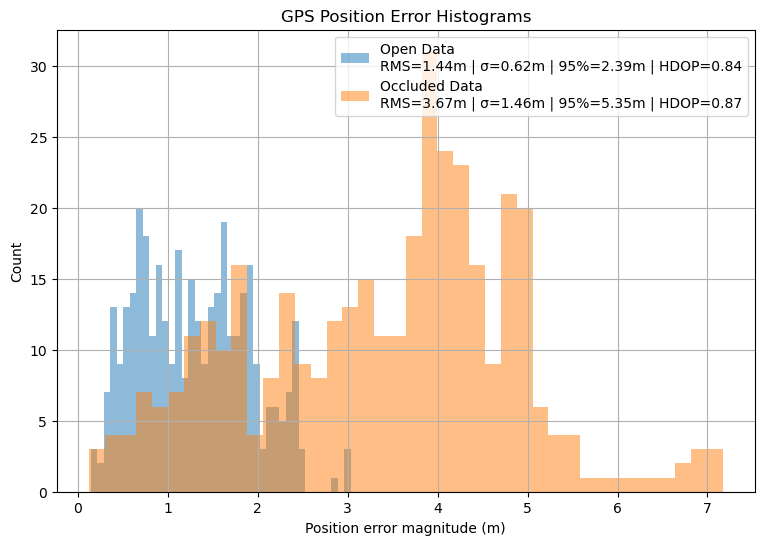

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_histograms(datasets, bins=40):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(9,6))

    for df, label in datasets:

        # known position = mean
        E_known = df['utm_easting'].mean()
        N_known = df['utm_northing'].mean()

        dE = df['utm_easting'] - E_known
        dN = df['utm_northing'] - N_known
        error = np.sqrt(dE**2 + dN**2)

        # stats
        rms = np.sqrt((error**2).mean())
        std = error.std()
        p95 = np.percentile(error, 95)
        hdop = df['hdop'].mean()

        legend_label = (
            f"{label}\n"
            f"RMS={rms:.2f}m | σ={std:.2f}m | 95%={p95:.2f}m | HDOP={hdop:.2f}"
        )

        plt.hist(error, bins=bins, alpha=0.5, label=legend_label)

    plt.xlabel("Position error magnitude (m)")
    plt.ylabel("Count")
    plt.title("GPS Position Error Histograms")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_error_histograms([
    (open_data, 'Open Data'),
    (occluded_data, 'Occluded Data'),
])


In [ ]:
# plot_error_histograms([
#     (straight_line_data, 'Straight Line Data'),
# ])

In [26]:
def plot_altitude_vs_time_all(datasets):
    """
    datasets = list of (df, label) tuples
    """

    plt.figure(figsize=(10,5))

    for df, label in datasets:

        t = (df['bag_time_ns'] - df['bag_time_ns'].iloc[0]) / 1e9
        alt = df['altitude']

        plt.scatter(t, alt, label=label, s=5)   # line is nicer than scatter here

    plt.xlabel("Time (s)")
    plt.ylabel("Altitude (m)")
    plt.title("Altitude vs Time Comparison")
    plt.legend()
    plt.grid(True)

    plt.show()


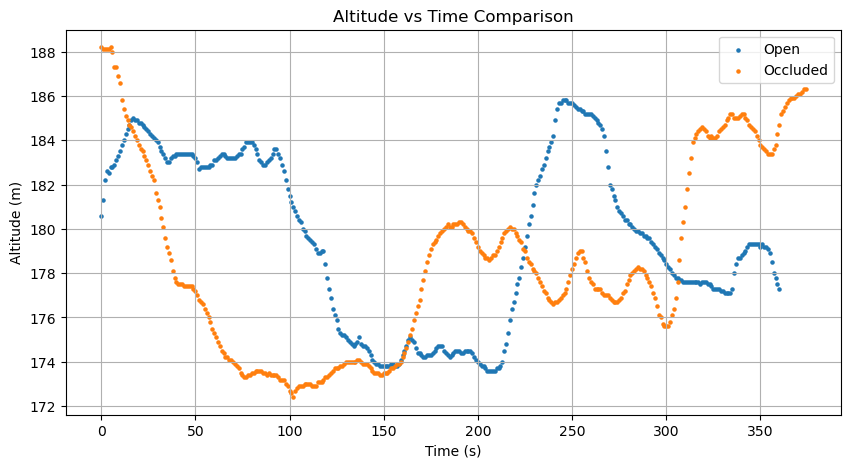

In [27]:
plot_altitude_vs_time_all([
    (open_data, "Open"),
    (occluded_data, "Occluded"),
    # (straight_line_data, "Straight Line"),
])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_fit_error(df, title):

    E = df['utm_easting'].values
    N = df['utm_northing'].values

    # ---- fit line ----
    m, b = np.polyfit(E, N, 1)
    N_fit = m*E + b

    # ---- perpendicular distance (cross-track error) ----
    error = np.abs(m*E - N + b) / np.sqrt(m**2 + 1)

    # stats
    rms = np.sqrt((error**2).mean())
    std = error.std()
    p95 = np.percentile(error, 95)

    # ---- plot ----
    plt.figure(figsize=(10,10))

    plt.scatter(E, N, s=6, alpha=0.6)

    legend_label = (
        
        f"RMS Cross Track = {rms:.2f} m\n"
        f"σ = {std:.2f} m\n"
        f"95% = {p95:.2f} m"
    )

    plt.plot(E, N_fit, 'r', linewidth=2)

    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    plt.title(title)
    plt.legend([legend_label])
    plt.gca().set_aspect('equal')
    plt.grid(True)

    plt.show()

    return error


plot_line_fit_error(straight_line_data, "Straight Line Data Cross-Track Error")

In [ ]:
# plot altitude vs time for straight line data
plot_altitude_vs_time_all([
    (straight_line_data, "Straight Line Data"),
])